
# MediChal Challenge - Detecting Malaria with cell Images

____

<img src="./logo.jpg" width="200" height="200" align="left"> 

## Team MEDICHAL :
- Théo Deschamps-Berger
- Simon Monteiro
- Xienneng Xu
- Nicolas Devatine
- Clément Veyssière
- Corentin Leloup
- Ramine Hamidi


<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>
        <br>       
 
     
The problem we try to solve here is the diagnosis of malaria using images of cells that are whether infected or not. It is a binary classification problem from the data set found here at <a href=https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria>"Cell images for detecting malaria"</a>. The data set contains around 27 thousand images, that are balanced between the 2 classes. The way we proceed here is to extract features from the images instead of using images directly as inputs to the model we use for predictions.

 
</div>

<p align="center">
  <img src="example_cells.png">
</p>
<center>Example of parasitized and uninfected cells</center>

In [1]:
import sys
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

### Quality of the data

Our data is composed of images that we preprocessed to extract features. Therefore we do not have any missing data in any feature because we created the features ourselves. There may be one artefact which is the fact that the background is black, and we may wonder if infected cells might be smaller (or the contrary), which would provide us darker images and a higher (or lower) average of gray 

In [2]:
data_dir = 'sample_data'              # Change this to the directory where you put the input data
data_name = 'malaria'

!ls $data_dir* # Linux command
# !dir $data_dir # Windows command

malaria_feat.name      malaria_test.data      malaria_valid.data
malaria_label.name     malaria_test.solution  malaria_valid.solution
malaria_private.info   malaria_train.data
malaria_public.info    malaria_train.solution


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

Reading sample_data/malaria_train from AutoML format
Number of examples = 600
Number of features = 19
         Class
0   uninfected
1  parasitized
Number of classes = 2


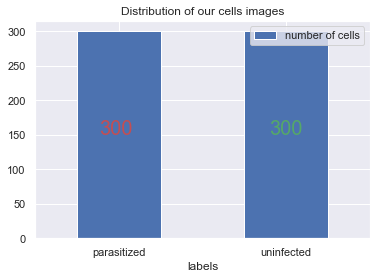

In [3]:
from data_io import read_as_df
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

nb_p=np.sum(data.target == 'parasitized')
nb_u=np.sum(data.target == 'uninfected')

p = pd.DataFrame({'labels':['parasitized', 'uninfected'],'number of cells': [nb_p, nb_u]})
ax = p.plot.bar(x='labels', y='number of cells', rot=0),
plt.text(-0.12, nb_p/2, nb_p , size=20, color='r'),
plt.text(0.9, nb_u/2, nb_u , size=20, color='g'),plt.title('Distribution of our cells images')
plt.show()

In [ ]:
data.head()

We have decided to reduce the dataset of images to a simpler dataset with only 19 features.

`nb_black_pixels` counts pixels whose value is dark for gray_scale images, those around the cell in the image.

`var_color` feature is simply the empirical variance of the values of the pixels for colored images.

`mean_color` feature is simply the mean of the values of the pixels for colored images.

`max_color` is the maximum value for colored images.

`min_color` is the maximum value for colored images.

`var_gray`, `mean_gray`, `max_gray` and `min_gray` are the same but for gray-scale images.

`nb_pixel_i_j` is the number of pixels having their value (intensity : 0 = black | 1 = white) between i and j for gray-scale images.

In [ ]:
data.describe() 

Histogram of our features:

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,16))

for t in range(19):
    plt.subplot(4,5,t+1)
    plt.hist(data[data.columns[t]])
    plt.title(data.columns[t])
    t+=1

Let's try to indentify patterns with a pairplot, which will maybe give us structures for each class depending on 2 features.

In [ ]:
sns.pairplot(data[['target','nb_black_pixels','var_color','mean_color','min_color','max_color','var_gray','mean_gray','min_gray','max_gray']], hue="target")

Correlation of our features with the target: 'parasitized'

In [ ]:
datatarget = pd.get_dummies(data['target'])['parasitized'].to_frame()
new_df = pd.merge(data, datatarget, right_index=True, left_index=True)
df_new = new_df.select_dtypes(include=np.number)

plt.figure(figsize = (10, 8))
ax = sns.heatmap(df_new.corr(),cmap="viridis", xticklabels=True, yticklabels=True)

d = pd.get_dummies(data['target'])['parasitized']

n_df = pd.merge(d.to_frame(), data, right_index=True, left_index=True)
df_n = n_df.select_dtypes(include=np.number).abs()


plt.figure(figsize = (2, 8))
ax = sns.heatmap(df_n.corr().abs().sort_values(['parasitized'], ascending=[0])["parasitized"].to_frame(), cmap="viridis", xticklabels=True, yticklabels=True)

In [ ]:
boxplot = data.boxplot(column=['nb_black_pixels'], by='target', )

There seem to have no correlation between the number of black pixels and the target as well, then there is no dataleakage.

From the correlation matrix, the feature that has the highest correlation with the target is "min_gray".

In [ ]:
boxplot = data.boxplot(column=['min_gray'], by='target', )

## Model and results analysis

Here we run a sandbox test to introduce some metrics and ways to visualize results. We split the train set into train and test in order to perform these analysis, and we compute the confusion matrix for RandomForestClassifier with arbitrary hyper-parameters.

In [4]:
from sklearn.model_selection import train_test_split
from data_manager import DataManager
from model import model
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

D = DataManager(data_name, data_dir, replace_missing=True)
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(D.data['X_train'], D.data['Y_train'], test_size=0.33, random_state=42)

# Load model
# tableau des 5 modèles choisis
classifiers = [
    RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None, max_features=None, min_samples_split=2),
    MLPClassifier(solver='lbfgs'),
    SGDClassifier(),
    GaussianNB(),
    KNeighborsClassifier()
]

# tableau des noms des classifieurs
name_classifiers = [
    'RandomForestClassifier',
    'MLPClassifier',
    'SGDClassifier',
    'GaussianNB',
    'KNeighborsClassifier'
]

# tableau des résultats pour chaque model
results = []
for i in classifiers:
    M = model(i)
    if not M.is_trained:
        M.fit(X_train_pre, y_train_pre)
    results.append(M.predict(X_test_pre))

# tableau des matrices de confusion sur les résultats des 5 modèles
matrices = []
for i in results:
    matrices.append(confusion_matrix(y_test_pre, i))

Info file found : /Users/patault/Documents/GitHub/Africa/starting_kit/sample_data/malaria_public.info
FIT: dim(X)= [402, 19]
FIT: dim(y)= [402, 1]
PREDICT: dim(X)= [198, 19]
PREDICT: dim(y)= [198, 1]
FIT: dim(X)= [402, 19]
FIT: dim(y)= [402, 1]
PREDICT: dim(X)= [198, 19]
PREDICT: dim(y)= [198, 1]
FIT: dim(X)= [402, 19]
FIT: dim(y)= [402, 1]
PREDICT: dim(X)= [198, 19]
PREDICT: dim(y)= [198, 1]
FIT: dim(X)= [402, 19]
FIT: dim(y)= [402, 1]
PREDICT: dim(X)= [198, 19]
PREDICT: dim(y)= [198, 1]
FIT: dim(X)= [402, 19]
FIT: dim(y)= [402, 1]
PREDICT: dim(X)= [198, 19]
PREDICT: dim(y)= [198, 1]


This is the plot of the confusion matrix from the predictions performed.

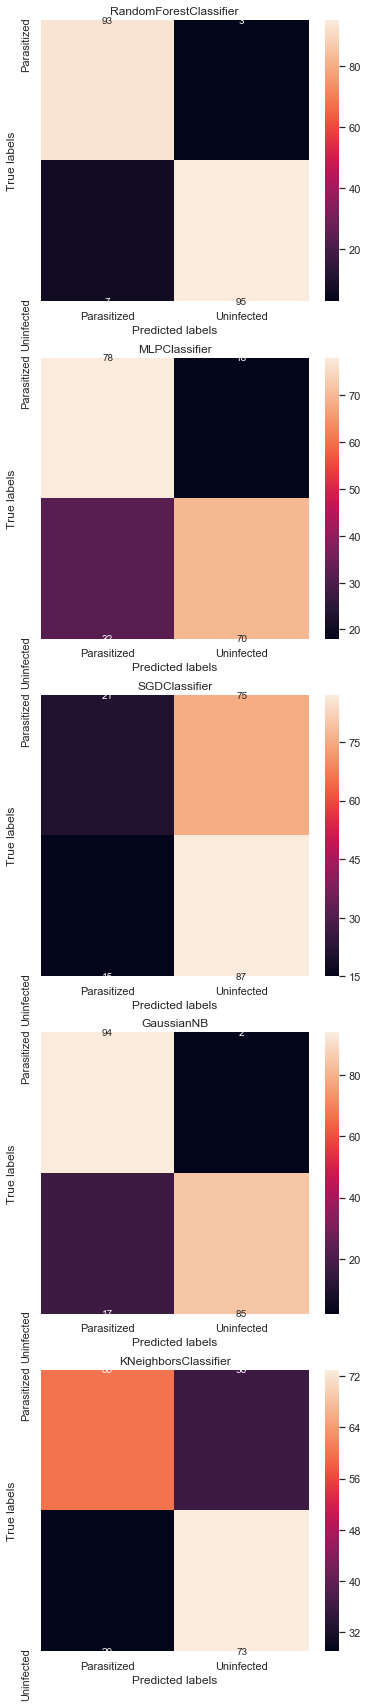

In [5]:
fig, ax = plt.subplots(nrows=5,ncols=1, figsize=(6, 30))
for i in range(5):
    sns.heatmap(matrices[i], annot=True, fmt='g', ax=ax[i]) #annot=True to annotate cells
    # labels, title and ticks
    ax[i].set_xlabel('Predicted labels')
    ax[i].set_ylabel('True labels')
    ax[i].set_title(name_classifiers[i]) 
    ax[i].xaxis.set_ticklabels(['Parasitized', 'Uninfected'])
    ax[i].yaxis.set_ticklabels(['Parasitized', 'Uninfected'])

plt.show()

In [6]:
mean = 0
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

target_names = ['Parasitized', 'Uninfected']
for i in range(0, len(results)):
    mean += round(scoring_function(y_test_pre, results[i]), 4)
    print("Score for "+ name_classifiers[i] + " : \n", round(scoring_function(y_test_pre, results[i]),4))
mean /= len(results)
print('\n ----> mean =', mean, '\n')

Using scoring metric: roc_auc_score
Score for RandomForestClassifier : 
 0.9501
Score for MLPClassifier : 
 0.7494
Score for SGDClassifier : 
 0.5358
Score for GaussianNB : 
 0.9063
Score for KNeighborsClassifier : 
 0.6703

 ----> mean = 0.7623800000000001 



<div>
Nous avons pu remarquer que le modèle des Random Forest possédait le meilleur score des 5 modèles testés.
Le paramètre le plus important est n_estimator correspondant au nombre d'arbres de décision dans notre Random Forest.
Plus ce nombre est important, plus la prédiction sera meilleure, jusqu'à un certain stade à cause du sur-apprentissage.
max_depth et max_features correspondent respectivement à la profondeur maximum d'un arbre et le nombre de features
à tester sur chaque arbre. En mettant ces deux paramètres à None, cela permet de tester chaque feature sur chaque arbre, permettant de meilleur résultats en contrepartie d'un temps de calcul plus long.
</div>

In [25]:
'''Find best hyper-parameters (of the best model) with RandomizedSearchCV or GridSearchCV'''


from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = classifiers[0],
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1) 

In [27]:
# /!\ ~5 MIN DE CHARGEMENT
rf_random.fit(X_train_pre, y_train_pre)   

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=10,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=5,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=2000,
                                                    n_jobs=None,
  

In [53]:
def evaluate(name, model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * (np.mean(errors) / np.mean(test_labels))
    accuracy = 100 - mape
    
    print(name, 'Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train_pre, y_train_pre)
base_accuracy = evaluate('Baseline', base_model, X_train_pre, y_train_pre)

best_random = rf_random.best_estimator_
random_accuracy = evaluate('Upgraded', best_random, X_train_pre, y_train_pre)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Baseline Model Performance
Average Error: 0.0124 degrees.
Accuracy = 97.47%.

Upgraded Model Performance
Average Error: 0.0075 degrees.
Accuracy = 98.48%.

Improvement of 1.04%.


Then we can compute the AUC metric which is the one used for the submission.

<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [55]:
from data_io import write
from model import model

??model

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> Keep this, it illustrates how data in AutoML formal are loaded by the ingestion program </span>
</div>

In [56]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /Users/patault/Documents/GitHub/Africa/starting_kit/sample_data/malaria_public.info
DataManager : malaria
info:
	usage = Malaria cell images dataset
	name = malaria
	task = binary.classification
	target_type = Numerical
	feat_type = Numerical
	metric = roc_auc_score
	time_budget = 1200
	feat_num = 19
	target_num = 2
	label_num = 2
	train_num = 600
	valid_num = 200
	test_num = 200
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(600, 19)
	Y_train = array(600,)
	X_valid = array(200, 19)
	Y_valid = array(200,)
	X_test = array(200, 19)
	Y_test = array(200,)
feat_type:	array(19,)
feat_idx:	array(0,)



In [66]:
M = model(best_random)   
trained_model_name = model_dir + data_name

M = M.load(trained_model_name)                  

Model reloaded from: sample_code_submission/malaria_model.pickle


<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [67]:
if not(M.is_trained):
    X_train = D.data['X_train']
    Y_train = D.data['Y_train']
    M.fit(X_train, Y_train)                     

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

PREDICT: dim(X)= [600, 19]
PREDICT: dim(y)= [600, 1]
PREDICT: dim(X)= [200, 19]
PREDICT: dim(y)= [200, 1]
PREDICT: dim(X)= [200, 19]
PREDICT: dim(y)= [200, 1]


<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [68]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/malaria_test.predict
sample_result_submission/malaria_train.predict
sample_result_submission/malaria_valid.predict


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

We use the area under the curve as our metric to evaluate our model for the moment. We chose this metric because accuracy gives us only the percentage of correctly classified examples, whereas what we are interested in is to have the lowest possible rate of false negatives (infected cells classifies as being healthy). The ROC curve we will get will help us to find a good threshold for this classification, which will not necessarily the one maximising the accuracy as the false negatives are critical in our case (but the true negatives can always be rechecked by experts). The AUC will then give us the general performance of our model given the fact that we want to maximize true positives and true negatives.

In [64]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

target_names = ['Parasitized', 'Uninfected']
for i in range(0, len(results)):
    mean += round(scoring_function(y_test_pre, results[i]), 4)
    print("Score for "+ name_classifiers[i] + " : \n", round(scoring_function(y_test_pre, results[i]),4))
mean /= len(results)
print('\n ----> mean =', mean, '\n')

Using scoring metric: roc_auc_score
Score for RandomForestClassifier : 
 0.9501
Score for MLPClassifier : 
 0.7494
Score for SGDClassifier : 
 0.5358
Score for GaussianNB : 
 0.9063
Score for KNeighborsClassifier : 
 0.6703

 ----> mean = 0.9453512 



<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [65]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

NameError: name 'Y_train' is not defined

You can add here other scores and result visualization.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, Y_hat_train)

In [ ]:
from sklearn.metrics import roc_curve, auc

size = round(len(D.data['X_train'])/10)

probas_ = M.classifier.fit(D.data['X_train'][:size], D.data['Y_train'][:size].ravel()).predict_proba(D.data['X_train'][size:])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(D.data['Y_train'][size:].ravel(), probas_[:, 1])
roc_auc = auc(fpr, tpr)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 7))

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This plot of the ROC curve is a good indicator for us to find a good threshold for our model, here we will prefer a very low rate of false negatives (1 - true positives rate). If we really want something near to 100% true positives, we might consider a model giving us 40% of false positive rate, we might consider that threshold as a medical diagnosis is a critical application.

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

scores = []
print('CV score (95 perc. CI):\n-----------------------')    

for i in range(5) :
    M = model(classifiers[i])
    score = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    scores.append(score)
    print(name_classifiers[i], " : %0.2f (+/- %0.2f)" % (scores[i].mean(), scores[i].std() * 2))

In [ ]:
data2 = data.drop(['nb_black_pixels'], axis=1)
X_train2 = data2.drop(['target'], axis= 1)
X_train2
M = model(classifiers[0])
scores = cross_val_score(M, X_train2, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score without the black_pixels attribute (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
scores

The scores of our model with and without the nb_black_pixels attribute is the same. Therefore we can conclude that there is no data leakage.

____

### Feature importance

The advantage of using a Random forest models is that we can evaluate which feature in taken into account  when predicting the target classes, here you can have an idea of which feature was the most relevant for solving our task

In [ ]:
import pandas as pd

feature_importance = pd.DataFrame(M.classifier.feature_importances_,index= list(data)[:19], columns=['feature importance']).sort_values('feature importance', ascending = False)
feature_importance.plot.bar(figsize=(9,7))
plt.show()



<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [ ]:
scoring_output_dir = 'scoring_output'
!python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

## Parameter optimization to try to improve the area under the roc curve.

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

# import os
# import sys
# sys.stdout = open(os.devnull, 'w')

# Define the hyperparameters
hyperparameters = {
    'max_depth': [5, 10, 20,40], 
    'n_estimators' : [2,10, 20, 100] }

# Compute all combinations
parameter_grid = list(ParameterGrid(hyperparameters))

# Just a table to save the results
#resultsDF = pd.DataFrame(columns=['factors', 'regularization', 'alpha', 'auc'])
resultsDF = pd.DataFrame()

for parameter_combination in parameter_grid:    
    clf = RandomForestClassifier (random_state = 42, n_estimators =parameter_combination['n_estimators'],max_depth =parameter_combination['max_depth'])
    M = model (classifier=clf)
    
    
    scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    
    
    parameter_combination['auc'] = scores.mean()
    
    resultsDF = resultsDF.append(parameter_combination, ignore_index=True)
    
res = resultsDF.sort_values(by=['auc'], ascending=False)


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
from data_io import zipdir

the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)